In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
import seaborn as sns
%matplotlib inline

In [49]:
plt.style.use('ggplot')

In [50]:
df = pd.read_excel('./real_estate2.xlsx', engine='openpyxl')

In [51]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


In [52]:
df['elapsed'] = 2021 - df['year']

In [53]:
df['distance'].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [54]:
dis_arr = df['distance'].unique()

In [55]:
dis_arr

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [56]:
dis_dict = {dis_arr[0]:10, dis_arr[1]:15, dis_arr[2]:5, dis_arr[3]:20, dis_arr[4]:30, dis_arr[5]:np.nan}

In [57]:
dis_dict

{'徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩5分以内': 5, '徒歩15分超': 20, 'バス': 30, '-': nan}

In [58]:
df['distance2'] = df['distance'].apply(lambda x: dis_dict[x])

In [59]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,38,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,38,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,38,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,38,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,38,10.0


In [60]:
df = df.dropna()

In [61]:
df2 = df[['space', 'elapsed', 'distance2', 'value']]

In [62]:
df2.head()

,space,elapsed,distance2,value
0,70,38,10.0,910
1,70,38,10.0,1120
2,70,38,10.0,1190
3,70,38,10.0,1190
4,70,38,10.0,1190


/opt/anaconda3/envs/stan/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


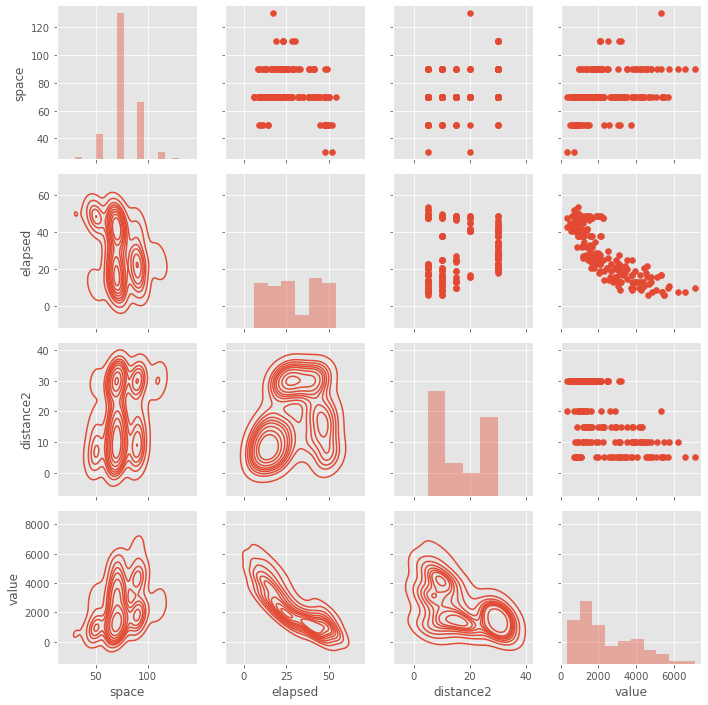

In [63]:
g = sns.PairGrid(df2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(plt.scatter)

In [64]:
stan_model = """
data {
  int N;
  real elapsed[N];
  real dis[N];
  real space[N];
  real Y[N];
}

parameters {
  real d;
  real s;
  real e;
  real b;
  real<lower=0> sigma;
}

model {
  real mu;
  for (n in 1:N){
    mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
    Y[n] ~ normal(mu, sigma);
  }
}
"""

In [65]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e9c3aa234f39d1a8227ee59f9a38fa5 NOW.
/opt/anaconda3/envs/stan/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/b0/3m9ppxz93zl2xj3hppxlrzbw0000gn/T/tmpxr0980ke/stanfit4anon_model_5e9c3aa234f39d1a8227ee59f9a38fa5_2963578511661951316.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [66]:
stan_data = {'N':df.shape[0], 'elapsed':df['elapsed'], 'dis':df['distance2'], 'space':df['space'], 'Y':df['value']}

In [67]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=4, seed=123)

In [68]:
fit

Inference for Stan model: anon_model_5e9c3aa234f39d1a8227ee59f9a38fa5.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
d     -57.57    0.08   5.07 -67.45 -60.97 -57.44 -54.14 -47.86   3567    1.0
s       24.5    0.07    3.5  17.75  22.09  24.46  26.78  31.49   2367    1.0
e     -67.66    0.07   3.71 -74.85 -70.24 -67.71 -65.14  -60.4   2858    1.0
b     3509.9    6.17 293.83 2917.8 3316.5 3515.1 3710.8 4076.7   2271    1.0
sigma 635.87     0.5  32.27 576.17 613.89 634.25 655.86 702.84   4205    1.0
lp__   -1363    0.03   1.59  -1367  -1364  -1362  -1362  -1361   2157    1.0

Samples were drawn using NUTS at Tue Aug 10 00:59:46 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

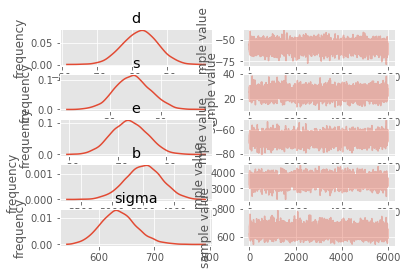

In [69]:
fig = fit.plot()